# Assignment 1
## Recreate Fama-French (1993) SMB and HML factors 

### Replication Procedure
1) Main data required is monthly returns, market equity, and book equity
    
    a) Use all non-financial firms (shrcd = 10, 11) which intersect the NYSE, AMEX and NASDAQ (exchcd = 1,2,3) from CRSP and the merged COMPUSTAT database for the financial statement data
    
    b) Data starts in 1962, however end of June of 1963 is first year, with t-1 data being from 1962  
    
2) Clean data appropriately

    a) BE is defined as COMPUSTATs book value of stockholders equity + balance-sheet deferred taxes - book value of preferred stock
    
    b) Negative BE firms are excluded

3) Organize necessary variables for each stock:

    a) Compute B/M_t as BE divided ME (both) in December of year t-1   
    
    b) ME_t as of June of year t
    
    c) All above variables are in logs
    
    d) Returns are computed monthly

4) Sort stocks based on Size and B/M
    
    a) B/M divded into Low, Medium and High, with the distinction for low as the lowest 30%, and high the highest 30%
    
    b) Size divided into Small and Big, with the distinction being the NYSE median breakpoint in June of year t
    
5) Compute value-weighted portfolio return from July of year t to June of year t+1, where the portfolio is rebalanced in June of t+1

6) Compute HML factor as the difference between the average portfolio returns for the High, Small and Big portfolios and the Low, Small and Big portfolios

7) Compute the SMB factor as the different between the average portfolio returns for the Small, L, M and H portfolios and the Big, L, M and H portfolios

### Data

In [2]:
# Imports
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from dateutil.relativedelta import *
from pandas.tseries.offsets import *
import pandas_datareader.data as pdr
from pandas_datareader.famafrench import get_available_datasets

#### Link to WRDS

In [199]:
import wrds
conn = wrds.Connection(wrds_username="santoromano")
# conn.create_pgpass_file()

Loading library list...
Done


#### Imports and Cleans COMPUSTAT Data

Gets data from COMPUSTAT North American - Fundamentals Annual file ('from comp.funda')

GVKEY is the unique company identifier

DATADATE is the date index

AT is total assets

PSTKL is preferred stock liquidation value

TXDITC is deferred taxes

PSTKRV is preferred stock redemption value

SEQ is book value of shareholders equity (CEQ + PSTK)

PSTK is total preferred stock

**Extra that WRDS code didn't include, but mention on Ken French's website**

CEQ is book value of common equity

UPSTK is the par value of preferred stock

LT is total liabilities

In [154]:
# comp = conn.raw_sql("""
#                     select gvkey, datadate, at, pstkl, txditc, pstkrv, seq, pstk, ceq, upstk, lt
#                     from comp.funda
#                     where indfmt='INDL' 
#                     and datafmt='STD'
#                     and popsrc='D'
#                     and consol='C'
#                     and datadate >= '01/01/1959'
#                     """, 
#                     date_cols=['datadate'])
# comp['year'] = comp['datadate'].dt.year

In [156]:
# comp.to_pickle("raw_compustat_data.pkl")

In [157]:
# comp = pd.read_pickle("raw_compustat_data.pkl")
comp

,gvkey,datadate,at,pstkl,txditc,pstkrv,seq,pstk,ceq,upstk,lt,year
0,001000,1961-12-31,NaN,0.0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,1961
1,001000,1962-12-31,NaN,0.0,NaN,NaN,NaN,0.0,0.552,NaN,NaN,1962
2,001000,1963-12-31,NaN,0.0,0.008,0.0,0.553,0.0,0.553,NaN,0.345,1963
3,001000,1964-12-31,1.416,0.0,0.020,0.0,0.607,0.0,0.607,NaN,0.809,1964
4,001000,1965-12-31,2.310,0.0,0.000,0.0,0.491,0.0,0.491,NaN,1.818,1965
...,...,...,...,...,...,...,...,...,...,...,...,...
45067,351491,2020-12-31,18841.000,0.0,13.000,0.0,2734.000,0.0,2734.000,NaN,16025.000,2020
45068,351590,2020-12-31,60256.041,0.0,119.333,0.0,9914.300,0.0,9914.300,NaN,49759.540,2020
45069,351590,2021-12-31,62325.449,0.0,77.338,0.0,18106.225,0.0,18106.225,NaN,43647.149,2021
45070,353444,2021-12-31,46650.000,0.0,4546.000,0.0,35687.000,0.0,35687.000,NaN,10793.000,2021


"Depending on availability, we use the redemption, liquidation, or par value (in that order) to estimate the book value of preferred stock" - Ken French's website

**Preferred Equity is correct**

In [158]:
# Preferred Equity
# either as redemption value, liquidation value or total, and fills blanks with 0
comp['ps']=np.where(comp['pstkrv'].isnull(), comp['pstkl'], comp['pstkrv'])
comp['ps']=np.where(comp['ps'].isnull(),comp['pstk'], comp['ps'])
comp['ps']=np.where(comp['ps'].isnull(),0,comp['ps'])

# Deferred Taxes & Investment Credits
comp['txditc']=comp['txditc'].fillna(0)

"Stockholders’ equity is the value reported by Moody’s or Compustat, if it is available. If not, we measure stockholders’ equity as the book value of common equity plus the par value of preferred stock, or the book value of assets minus total liabilities (in that order)" - Ken French's website

**v2: below correction improves breakpoint and overall factor correlation**

In [159]:
# Stockholders Equity
comp['se'] = np.where(comp['seq'].isnull(), comp['ceq']+comp['upstk'] , comp['seq'])
comp['se'] = np.where(comp['se'].isnull(), comp['at']-comp['lt'] , comp['se'])
comp['se'] = np.where(comp['se'].isnull(), 0 , comp['se'])

Book value of Equity = Stockholders Equity + Deferred Taxes & Investment Credits - Preferred Equity

(BE = SE + TXDITC - PS)

In [160]:
# Computes Book Equity
comp['be']=comp['se'] + comp['txditc'] - comp['ps']
comp['be']=np.where(comp['be']>0, comp['be'], np.nan) # if be is negative, set as NaN

In [161]:
# number of years in Compustat
comp=comp.sort_values(by=['gvkey','datadate'])
comp['count']=comp.groupby(['gvkey']).cumcount()

comp=comp[['gvkey','datadate','year','be','count']]

In [162]:
comp

,gvkey,datadate,year,be,count
0,001000,1961-12-31,1961,NaN,0
1,001000,1962-12-31,1962,NaN,1
2,001000,1963-12-31,1963,0.561,2
3,001000,1964-12-31,1964,0.627,3
4,001000,1965-12-31,1965,0.491,4
...,...,...,...,...,...
44868,351590,2019-12-31,2019,11161.229,0
45068,351590,2020-12-31,2020,10033.633,1
45069,351590,2021-12-31,2021,18183.563,2
45070,353444,2021-12-31,2021,40233.000,0


In [164]:
# Stores cleaned COMPUSTAT data locally
# comp.to_pickle("compustat_data.pkl")

#### Imports and Cleans Book Equity Data from Ken French's Website

In [188]:
historical_be = pd.read_excel('historical_book_equity_cleaned.xlsx', header=1)

In [189]:
historical_be

,permno,first_moody_year,last_moody_year,be_1926,be_1927,be_1928,be_1929,be_1930,be_1931,be_1932,...,be_1992,be_1993,be_1994,be_1995,be_1996,be_1997,be_1998,be_1999,be_2000,be_2001
0,10006,1926,1953,67.743,71.245,70.139,70.139,70.139,70.139,69.445,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.990,-99.99,-99.99,-99.99
1,10014,1926,1961,13.005,12.787,12.630,13.871,14.896,15.705,16.282,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.990,-99.99,-99.99,-99.99
2,10022,1926,1960,13.567,13.996,14.326,14.552,14.025,14.081,13.314,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.990,-99.99,-99.99,-99.99
3,10030,1926,1966,15.924,17.487,18.771,20.508,20.488,21.100,18.499,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.990,-99.99,-99.99,-99.99
4,10049,1926,1932,11.984,12.848,13.340,59.145,61.094,61.609,57.784,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.990,-99.99,-99.99,-99.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,86134,1998,1998,-99.990,-99.990,-99.990,-99.990,-99.990,-99.990,-99.990,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,550.995,-99.99,-99.99,-99.99
1790,86239,1937,1974,-99.990,-99.990,-99.990,-99.990,-99.990,-99.990,-99.990,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.990,-99.99,-99.99,-99.99
1791,86861,1998,1998,-99.990,-99.990,-99.990,-99.990,-99.990,-99.990,-99.990,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,426.523,-99.99,-99.99,-99.99
1792,92567,1989,1989,-99.990,-99.990,-99.990,-99.990,-99.990,-99.990,-99.990,...,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99,-99.990,-99.99,-99.99,-99.99


#### Imports and Cleans CRSP Data

Gets data from CRSP Monthly Stock File ("from crsp.msf")

Join with "event" file ("crsp.msenames") to get historical exchange and share code

PERMNO is the permanent issue number

PERMCO is the permanent company number

DATE is the date index

SHRCD is the share code

EXCHCD is the exchange code

RET is the holding period (monthly) total return

RETX is the holding period (monthly) price return (ie. excluding dividends)

SHROUT is the number of shares outstanding

PRC is the share price

In [3]:
# WRDS SQL Query

# crsp_m = conn.raw_sql("""
#                       select a.permno, a.permco, a.date, b.shrcd, b.exchcd,
#                       a.ret, a.retx, a.shrout, a.prc
#                       from crsp.msf as a
#                       left join crsp.msenames as b
#                       on a.permno=b.permno
#                       and b.namedt<=a.date
#                       and a.date<=b.nameendt
#                       where a.date between '01/01/1959' and '12/31/2022'
#                       and b.exchcd between 1 and 3
#                       """, date_cols=['date']) 

# # change variable format to int
# crsp_m[['permco','permno','shrcd','exchcd']]=crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# # Line up date to be end of month
# crsp_m['jdate']=crsp_m['date']+MonthEnd(0)

In [270]:
# # Add delisted return
# dlret = conn.raw_sql("""
#                      select permno, dlret, dlstdt 
#                      from crsp.msedelist
#                      """, date_cols=['dlstdt'])

# dlret.permno=dlret.permno.astype(int)
# #dlret['dlstdt']=pd.to_datetime(dlret['dlstdt'])
# dlret['jdate']=dlret['dlstdt']+MonthEnd(0)

# crsp = pd.merge(crsp_m, dlret, how='left',on=['permno','jdate'])

In [271]:
# crsp.to_pickle("raw_crsp_data.pkl")

In [190]:
crsp = pd.read_pickle("raw_crsp_data.pkl")

In [191]:
# crsp

In [192]:
crsp['dlret']=crsp['dlret'].fillna(0)
crsp['ret']=crsp['ret'].fillna(0)

# Return adjusted for delisting
crsp['retadj']=(1+crsp['ret'])*(1+crsp['dlret'])-1

# calculate market equity
crsp['me']=crsp['prc'].abs()*crsp['shrout'] 
crsp=crsp.drop(['dlret','dlstdt','prc','shrout'], axis=1)
crsp=crsp.sort_values(by=['jdate','permco','me'])

In [193]:
# Aggreate Market Cap
# The total market cap (across issues for the same company) is assigned to the 
# issue number with the highest market cap, and all other issues for the
# company are dropped
 
# Sum ME across different permno for same permco for a given date 
crsp_summe = crsp.groupby(['jdate','permco'])['me'].sum().reset_index()

# largest mktcap within a permco/date
crsp_maxme = crsp.groupby(['jdate','permco'])['me'].max().reset_index()

# Join by jdate/maxme to find the permno
crsp1=pd.merge(crsp, crsp_maxme, how='inner', on=['jdate','permco','me']) # df which only contains issue numbers w/ largest me
crsp1=crsp1.drop(['me'], axis=1)

# Joins with sum of me to get the correct market cap info
crsp2=pd.merge(crsp1, crsp_summe, how='inner', on=['jdate','permco'])

# sort by permno and date and also drop duplicates
crsp2=crsp2.sort_values(by=['permno','jdate']).drop_duplicates()

In [194]:
# December Market Cap
crsp2['year']=crsp2['jdate'].dt.year
crsp2['month']=crsp2['jdate'].dt.month
decme=crsp2[crsp2['month']==12]
decme=decme[['permno','date','jdate','me','year']].rename(columns={'me':'dec_me'})

# July to June dates
crsp2['ffdate']=crsp2['jdate']+MonthEnd(-6)
crsp2['ffyear']=crsp2['ffdate'].dt.year
crsp2['ffmonth']=crsp2['ffdate'].dt.month
crsp2['1+retx']=1+crsp2['retx']
crsp2=crsp2.sort_values(by=['permno','date'])

In [195]:
# Computes cummulative returns for every year
crsp2['cumretx']=crsp2.groupby(['permno','ffyear'])['1+retx'].cumprod()

# Lagged cummulative return and market cap
crsp2['lcumretx']=crsp2.groupby(['permno'])['cumretx'].shift(1)
crsp2['lme']=crsp2.groupby(['permno'])['me'].shift(1)

# if first permno then use me/(1+retx) to replace the missing value
crsp2['count']=crsp2.groupby(['permno']).cumcount()
crsp2['lme']=np.where(crsp2['count']==0, crsp2['me']/crsp2['1+retx'], crsp2['lme'])

# baseline me
mebase=crsp2[crsp2['ffmonth']==1][['permno','ffyear', 'lme']].rename(columns={'lme':'mebase'})

# merge result back together
crsp3=pd.merge(crsp2, mebase, how='left', on=['permno','ffyear'])
crsp3['wt']=np.where(crsp3['ffmonth']==1, crsp3['lme'], crsp3['mebase']*crsp3['lcumretx'])

# Increments December market cap by 1 year
decme['year']=decme['year']+1
decme=decme[['permno','year','dec_me']]

In [196]:
# Info as of June
crsp3_jun = crsp3[crsp3['month']==6]

# Merges December t-1 market cap with returns as of June t
crsp_jun = pd.merge(crsp3_jun, decme, how='inner', on=['permno','year'])
crsp_jun=crsp_jun[['permno','date', 'jdate', 'shrcd','exchcd','retadj','me','wt','cumretx','mebase','lme','dec_me']]
crsp_jun=crsp_jun.sort_values(by=['permno','jdate']).drop_duplicates()

In [256]:
# Stores cleaned CRSP data locally
# crsp_jun.to_pickle("crsp_data.pkl")
# crsp3.to_pickle("crsp3_data.pkl")

#### Merge CRSP and Compustat
Merge with CCM Link Table

##### Reads COMPUSTAT and CRSP Data locally

In [82]:
# comp = pd.read_pickle("compustat_data.pkl")
# crsp_jun = pd.read_pickle("crsp_data.pkl")

In [200]:
ccm=conn.raw_sql("""
                  select gvkey, lpermno as permno, linktype, linkprim, 
                  linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])

# if linkenddt is missing then set to today date
ccm['linkenddt']=ccm['linkenddt'].fillna(pd.to_datetime('today'))

# Merge COMPUSTAT and CCM Link Table on GVKEY
ccm1=pd.merge(comp[['gvkey','datadate','be', 'count']],ccm,how='left',on=['gvkey'])

# Adds in date columns for next June
ccm1['yearend']=ccm1['datadate']+YearEnd(0)
ccm1['jdate']=ccm1['yearend']+MonthEnd(6)

In [201]:
# Link only if June y is beyond the initial link date, and the final link date
ccm2=ccm1[(ccm1['jdate']>=ccm1['linkdt'])&(ccm1['jdate']<=ccm1['linkenddt'])]
ccm2=ccm2[['gvkey','permno','datadate','yearend', 'jdate','be', 'count']]

# COMPUSTAT and CRSP Merge
ccm_jun=pd.merge(crsp_jun, ccm2, how='inner', on=['permno', 'jdate'])
ccm_jun['beme']=ccm_jun['be']*1000/ccm_jun['dec_me']

In [258]:
# ccm_jun.to_pickle("compustat_crsp_merged.pkl")

### Constructs 2x3 Sort

In [259]:
# ccm_jun = pd.read_pickle("compustat_crsp_merged.pkl")
# crsp3 = pd.read_pickle("crsp3_data.pkl")

In [202]:
# Selects NYSE stocks for bucket breakdown
# exchcd = 1 and positive beme and positive me and shrcd in (10,11) and at least 2 years in comp
nyse=ccm_jun[(ccm_jun['exchcd']==1) & (ccm_jun['beme']>0) & (ccm_jun['me']>0) & \
             (ccm_jun['count']>=1) & ((ccm_jun['shrcd']==10) | (ccm_jun['shrcd']==11))]

In [203]:
# Size and BE/ME Breakdown

# Size
nyse_sz=nyse.groupby(['jdate'])['me'].median().to_frame().reset_index().rename(columns={'me':'sizemedn'})

# BE/ME
nyse_bm=nyse.groupby(['jdate'])['beme'].describe(percentiles=[0.3, 0.7]).reset_index()
nyse_bm=nyse_bm[['jdate','30%','70%']].rename(columns={'30%':'bm30', '70%':'bm70'})

nyse_breaks = pd.merge(nyse_sz, nyse_bm, how='inner', on=['jdate'])

# join back size and beme breakdown
ccm1_jun = pd.merge(ccm_jun, nyse_breaks, how='left', on=['jdate'])

In [204]:
# function to assign sz and bm bucket
def sz_bucket(row):
    if row['me']==np.nan:
        value=''
    elif row['me']<=row['sizemedn']:
        value='S'
    else:
        value='B'
    return value

def bm_bucket(row):
    if 0<=row['beme']<=row['bm30']:
        value = 'L'
    elif row['beme']<=row['bm70']:
        value='M'
    elif row['beme']>row['bm70']:
        value='H'
    else:
        value=''
    return value

In [205]:
nyse_breaks

,jdate,sizemedn,bm30,bm70
0,1961-06-30,1.688960e+05,0.513463,1.040504
1,1962-06-30,9.910000e+04,0.420854,0.778001
2,1963-06-30,1.083585e+05,0.510189,1.057739
3,1964-06-30,1.138132e+05,0.483881,0.898171
4,1965-06-30,1.239408e+05,0.437157,0.841103
...,...,...,...,...
56,2017-06-30,3.065053e+06,0.302826,0.668757
57,2018-06-30,3.293754e+06,0.284741,0.655523
58,2019-06-30,3.108495e+06,0.352487,0.872011
59,2020-06-30,2.540818e+06,0.308972,0.770254


#### Comparison Breakpoints from Ken French's website
   
<font size=4 color=red>
v1: 
    
Size breakpoints are completely different in magnitude, but are 99.9% correlated (correlationimproved marginally with amended BE calculation)

Book to market breakpoints are similar in magnitude but not close enough (improved substantially with amended BE calculation)    

v2: 
    
Notes: Size breakpoints unchanged. Values in latter sample appear to be scaled by 1000. Refer to Plot
    
Book to market breakpoints closer in early sample, farther in latter sample, using ['(20, 25)', '(60, 65)'], compared to '(25, 30)', '(65, 70)']
<font>

In [274]:
my_breakpoints = nyse_breaks.copy()
my_breakpoints.index = my_breakpoints['jdate']
my_breakpoints.index = my_breakpoints.index.to_period('M')
# my_breakpoints

In [275]:
# get_available_datasets()
size_breakpoints = pdr.DataReader('ME_Breakpoints','famafrench', start='1961-06-01')[0]
size_breakpoints.columns = size_breakpoints.columns.map(str)

be_breakpoints = pdr.DataReader('BE-ME_Breakpoints','famafrench', start='1961-06-01')[0]
be_breakpoints.columns = be_breakpoints.columns.map(str)

In [282]:
median_size = size_breakpoints.loc[::12,'(45, 50)']
size_breaks = pd.merge(my_breakpoints['sizemedn'], median_size, left_index=True, right_index=True)
size_breaks

,sizemedn,"(45, 50)"
1961-06,1.688960e+05,77.77
1962-06,9.910000e+04,58.79
1963-06,1.083585e+05,72.94
1964-06,1.138132e+05,80.33
1965-06,1.239408e+05,85.19
...,...,...
2017-06,3.065053e+06,2826.85
2018-06,3.293754e+06,3228.94
2019-06,3.108495e+06,3047.61
2020-06,2.540818e+06,2579.76


In [283]:
size_breaks.corr()

,sizemedn,"(45, 50)"
sizemedn,1.000000,0.999373
"(45, 50)",0.999373,1.000000


##### Size Breakpoints Plot

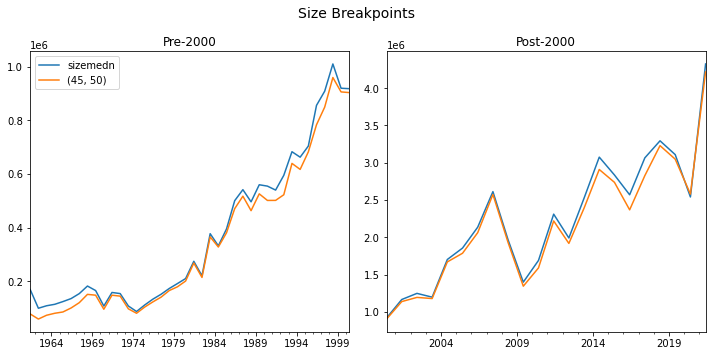

In [320]:
test = size_breaks.copy()
test['(45, 50)'] = test['(45, 50)']*1000

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Pre-2000 plot
ax1 = test.loc[:'2000'].plot(ax=axes[0], legend=False)
ax1.set_title("Pre-2000")
ax1.set_xlabel("")
ax1.legend(loc="upper left")

# Post-2000 plot
ax2 = test.loc['2000':].plot(ax=axes[1], legend=False)
ax2.set_title("Post-2000")
ax2.set_xlabel("")

fig.suptitle('Size Breakpoints', fontsize=14)


plt.tight_layout()
# plt.savefig("Size Breakpoints")

In [269]:
# my_breakpoints.index = my_breakpoints.index.year
# my_breakpoints.index = pd.PeriodIndex(my_breakpoints.index, freq="A")

be_30_70 = be_breakpoints.loc[:,['(20, 25)', '(60, 65)']] # matches perfectly
# be_30_70 = be_breakpoints.loc[:,['(25, 30)', '(65, 70)']] 

be_breaks = pd.merge(my_breakpoints[['bm30','bm70']], be_30_70, left_index=True, right_index=True)
be_breaks

,bm30,bm70,"(20, 25)","(60, 65)"
1961,0.513463,1.040504,0.510,1.049
1962,0.420854,0.778001,0.419,0.871
1963,0.510189,1.057739,0.511,1.073
1964,0.483881,0.898171,0.478,0.932
1965,0.437157,0.841103,0.432,0.858
...,...,...,...,...
2017,0.302826,0.668757,0.246,0.540
2018,0.284741,0.655523,0.235,0.554
2019,0.352487,0.872011,0.282,0.715
2020,0.308972,0.770254,0.242,0.649


In [270]:
be_breaks.corr()

,bm30,bm70,"(20, 25)","(60, 65)"
bm30,1.000000,0.975718,0.992646,0.980792
bm70,0.975718,1.000000,0.956047,0.982669
"(20, 25)",0.992646,0.956047,1.000000,0.981039
"(60, 65)",0.980792,0.982669,0.981039,1.000000


#### Portfolios based on Levels

In [230]:
# Size portfolio
ccm1_jun['szport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(sz_bucket, axis=1), '')

# Book-to-market portfolio
ccm1_jun['bmport']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), ccm1_jun.apply(bm_bucket, axis=1), '')

# Create positive BE/ME and non-missing book-to-market portfolio variable
ccm1_jun['posbm']=np.where((ccm1_jun['beme']>0)&(ccm1_jun['me']>0)&(ccm1_jun['count']>=1), 1, 0)
ccm1_jun['nonmissport']=np.where((ccm1_jun['bmport']!=''), 1, 0)

In [231]:
# Store portfolio assignment as of June
june=ccm1_jun[['permno','date', 'jdate', 'bmport','szport','posbm','nonmissport']]
june['ffyear']=june['jdate'].dt.year

# Merge back with monthly records
crsp3 = crsp3[['date','permno','shrcd','exchcd','retadj','me','wt','cumretx','ffyear','jdate']]
ccm3 = pd.merge(crsp3, june[['permno','ffyear','szport','bmport','posbm','nonmissport']], how='left', on=['permno','ffyear'])

# Keeping only records that meet the criteria
ccm4 = ccm3[(ccm3['wt']>0) & (ccm3['posbm']==1) & (ccm3['nonmissport']==1) & 
          ((ccm3['shrcd']==10) | (ccm3['shrcd']==11))]

C:\Users\sroma\AppData\Local\Temp\ipykernel_24652\1506937354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  june['ffyear']=june['jdate'].dt.year


### Portfolio & Factor Construction

In [232]:
# function to calculate value weighted return
def wavg(group, avg_name, weight_name):
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

#### Factors based on Levels

In [233]:
# Value-weigthed return
vwret = ccm4.groupby(['jdate','szport','bmport']).apply(wavg, 'retadj','wt').to_frame().reset_index().rename(columns={0: 'vwret'})
vwret['sbport'] = vwret['szport'] + vwret['bmport']

# Firm count
vwret_n = ccm4.groupby(['jdate','szport','bmport'])['retadj'].count().reset_index().rename(columns={'retadj':'n_firms'})
vwret_n['sbport'] = vwret_n['szport']+vwret_n['bmport']

# tranpose
ff_factors = vwret.pivot(index='jdate', columns='sbport', values='vwret').reset_index()
ff_nfirms = vwret_n.pivot(index='jdate', columns='sbport', values='n_firms').reset_index()

In [234]:
# create SMB and HML factors
ff_factors['WH']=(ff_factors['BH']+ff_factors['SH'])/2
ff_factors['WL']=(ff_factors['BL']+ff_factors['SL'])/2
ff_factors['WHML'] = ff_factors['WH']-ff_factors['WL']

ff_factors['WB']=(ff_factors['BL']+ff_factors['BM']+ff_factors['BH'])/3
ff_factors['WS']=(ff_factors['SL']+ff_factors['SM']+ff_factors['SH'])/3
ff_factors['WSMB'] = ff_factors['WS']-ff_factors['WB']
ff_factors=ff_factors.rename(columns={'jdate':'date'})

# n firm count
ff_nfirms['H']=ff_nfirms['SH']+ff_nfirms['BH']
ff_nfirms['L']=ff_nfirms['SL']+ff_nfirms['BL']
ff_nfirms['HML']=ff_nfirms['H']+ff_nfirms['L']

ff_nfirms['B']=ff_nfirms['BL']+ff_nfirms['BM']+ff_nfirms['BH']
ff_nfirms['S']=ff_nfirms['SL']+ff_nfirms['SM']+ff_nfirms['SH']
ff_nfirms['SMB']=ff_nfirms['B']+ff_nfirms['S']
ff_nfirms['TOTAL']=ff_nfirms['SMB']
ff_nfirms=ff_nfirms.rename(columns={'jdate':'date'})

In [235]:
ff_factors

sbport,date,BH,BL,BM,SH,SL,SM,WH,WL,WHML,WB,WS,WSMB
0,1961-07-31,0.019238,0.026393,0.045672,0.007220,0.017651,0.015215,0.013229,0.022022,-0.008793,0.030434,0.013362,-0.017073
1,1961-08-31,0.011445,0.031552,0.010885,0.019749,0.023673,0.013036,0.015597,0.027613,-0.012016,0.017960,0.018819,0.000859
2,1961-09-30,-0.040536,-0.000365,-0.037356,-0.031354,-0.033206,-0.033228,-0.035945,-0.016785,-0.019160,-0.026086,-0.032596,-0.006510
3,1961-10-31,0.034209,0.026839,0.020104,0.018590,0.010186,0.017174,0.026399,0.018512,0.007887,0.027050,0.015317,-0.011734
4,1961-11-30,0.048651,0.039687,0.056854,0.050767,0.072879,0.045340,0.049709,0.056283,-0.006574,0.048398,0.056329,0.007931
...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,2021-11-30,-0.045823,-0.000943,-0.031771,-0.035349,-0.068801,-0.013955,-0.040586,-0.034872,-0.005714,-0.026179,-0.039369,-0.013190
725,2021-12-31,0.050632,0.026028,0.060611,0.043962,-0.002917,0.040213,0.047297,0.011555,0.035742,0.045757,0.027086,-0.018671
726,2022-01-31,0.055996,-0.079990,-0.036992,-0.008605,-0.133200,-0.088411,0.023696,-0.106595,0.130291,-0.020329,-0.076738,-0.056410
727,2022-02-28,0.009915,-0.038324,-0.003456,0.024701,-0.000739,0.009384,0.017308,-0.019532,0.036839,-0.010622,0.011115,0.021737


### Compare with actual Factors from Ken French Data

In [240]:
# get_available_datasets

In [241]:
# real_ff_factors = pdr.DataReader('6_Portfolios_2x3','famafrench', start='1963-07-01')
# real_ff_factors = real_ff_factors[0]

# real_ff_factors['real_HML'] = (real_ff_factors["SMALL HiBM"] + real_ff_factors["BIG HiBM"])/2 - (real_ff_factors["SMALL LoBM"] + real_ff_factors["BIG LoBM"])/2
# real_ff_factors['real_SMB'] = (real_ff_factors["SMALL LoBM"] + real_ff_factors["ME1 BM2"] + real_ff_factors["SMALL HiBM"])/3 - \
#                          (real_ff_factors["BIG LoBM"] + real_ff_factors["ME2 BM2"] + real_ff_factors["BIG HiBM"])/3

# real_ff_factors.to_pickle("real_ff_factors.pkl")

In [242]:
real_ff_factors = pd.read_pickle("real_ff_factors.pkl")

In [309]:
ff_factors.index = ff_factors['date']
ff_factors.index = ff_factors.index.to_period('M')

compare_factors = pd.merge(ff_factors[['WSMB','WHML']], 
                           real_ff_factors[['real_SMB','real_HML']]/100,
                           how='inner', left_index=True, right_index=True)

In [310]:
# compare_factors

In [311]:
display(compare_factors.corr().style.set_caption('Factor Correlations'))
display(compare_factors.describe().style.set_caption('Factor Summary Statistics'))

,WSMB,WHML,real_SMB,real_HML
WSMB,1.000000,-0.202592,0.994938,-0.152921
WHML,-0.202592,1.000000,-0.206970,0.981443
real_SMB,0.994938,-0.206970,1.000000,-0.169570
real_HML,-0.152921,0.981443,-0.169570,1.000000


,WSMB,WHML,real_SMB,real_HML
count,705.000000,705.000000,705.000000,705.000000
mean,0.002083,0.002790,0.001901,0.002934
std,0.030416,0.029854,0.030527,0.029383
min,-0.170665,-0.136451,-0.172285,-0.139727
25%,-0.016261,-0.014067,-0.016615,-0.013809
50%,0.000811,0.002621,0.001186,0.002348
75%,0.019787,0.016605,0.020251,0.017451
max,0.223343,0.137679,0.214248,0.127537


#### Analysis
...

#### Grade

50 × Corr(RYours, RFF) + 25 × (1 −|μYours − μFF|) + 25 × (1−|σYours − σFF|), 

In [312]:
grade = 50*compare_factors.corr().loc["WHML","real_HML"] \
        + 25*(1 - abs(compare_factors.describe()['WHML'].loc["mean"] - compare_factors.describe()['real_HML'].loc["mean"])) \
        + 25*(1 - abs(compare_factors.describe()['WHML'].loc["std"] - compare_factors.describe()['real_HML'].loc["std"]))
grade

99.0567550678

#### Plot

<AxesSubplot:>

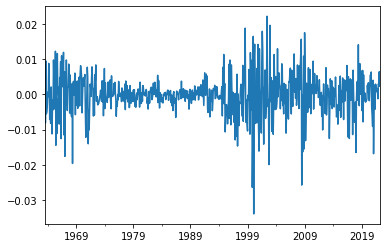

In [252]:
hml_plot = compare_factors[["WHML",'real_HML']].copy()
hml_plot['real_HML'] = hml_plot['real_HML'] / 100
hml_plot['hml_diff'] = hml_plot['WHML'] - hml_plot['real_HML'] 
hml_plot['hml_diff'].plot()

##### v0 Results (based on old BE calculation)
formula to subtract the mean was not correct

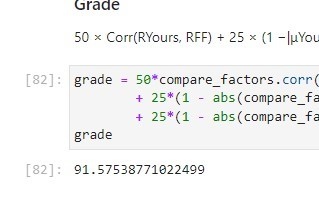